# Método ML: K-Nearest Regressor
## Time serie: Pozo Izquierdo ME
### height from the ground:40 mtos.
Field: wind

In [7]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.regression import mean_squared_error
from sklearn.metrics.regression import mean_absolute_error
from sklearn.externals import joblib

In [8]:
# cargamos el horizonte de la serie a predecir con las features
df_v40_hour_h1 = pd.read_csv('../02_preproceso/pozo_izquierdo_torre_me_h_1.csv', delimiter=';')
df_v40_hour_h1.head()

,target_date,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,target
0,2004-07-01 00:10:00,9.6,9.6,9.8,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5
1,2004-07-01 00:11:00,9.6,9.8,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2
2,2004-07-01 00:12:00,9.8,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2,12.3
3,2004-07-01 00:13:00,9.6,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2,12.3,11.7
4,2004-07-01 00:14:00,10.2,10.2,10.8,10.5,10.4,10.7,11.5,12.2,12.3,11.7,12.5


In [9]:
def dataframe_split(df):
    """
    Split a pandas dataframe in three dataframe. 
    :df: pandas dataframe 
    :return: a dictionary where the value of the key is a pandas dataframe.
             each dataframe has a time measure, features and the target variable.
    """
    # split the original dataframe in two dataframe. 
    # 80 % train and 20 % test set.
    train_size = int((df.shape[0] * 80) / 100)
    # Test set.
    df_train_set = df.iloc[0:train_size]
    df_test_set = df.iloc[train_size:]
    # Split train set in train and validation set using the method of
    # scikit-learn 'train_test_split'.
    df_train_set, df_validation_set = train_test_split(df_train_set, test_size=0.2)
    
    return {'train_set' : df_train_set,
            'validation_set': df_validation_set,
            'test_set': df_test_set}

In [10]:
data = dataframe_split(df_v40_hour_h1)
# dfs: train, validation and test set
train_set = data['train_set']
validation_set = data['validation_set']
test_set = data['test_set']

In [11]:
# bug: the original time seria has null values.
train_set = train_set.fillna(0.0)
validation_set = validation_set.fillna(0.0)

## K-nearest regression

### Hyperparameters
* n_neighbors = 5
* weights = ['uniform', 'distance', 'callable']

### Fit the model

In [12]:
# features and target columns
features_columns = train_set.columns[1:-1]
target_column = train_set.columns[-1:]

# select the values of features and target columns.
features_train_set = train_set[features_columns]
target_train_set = train_set[target_column]
features_validation_set = validation_set[features_columns]
target_validation_set = validation_set[target_column]

In [13]:
history = {} # dictionary with all metrics
mse = [] ; val_mse = [] # mean squared error
number_neighbors = range(2,70, 2)
for n_neighbors in number_neighbors:
    knr = KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform')
    knr = knr.fit(features_train_set, target_train_set)
    # save the model in joblib file
    joblib.dump(knr, 'n-nearest_regressor_{0}'.format(n_neighbors))
    # overfitting: evaluate train and validation set on the fitted model. 
    evaluate_train = knr.predict(features_train_set)
    evaluate_validation = knr.predict(features_validation_set)
    # metric calculation
    mse_train = mean_squared_error(target_train_set[['target']].values, evaluate_train)
    mse_validation = mean_absolute_error(target_validation_set[['target']].values, 
                                         evaluate_validation)
    mse.append(mse_train); val_mse.append(mse_validation)
    #mean_squared_error()
    #mean_absolute_error()

history['mse'] = mse
history['val_mse'] = val_mse

In [15]:
#history

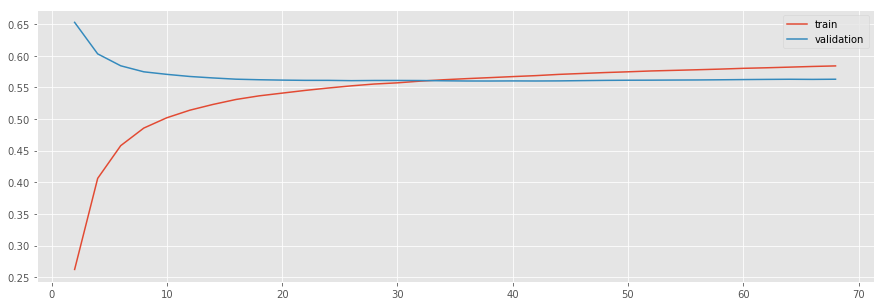

In [16]:
f = plt.figure(figsize=(15,5))
plt.plot(list(number_neighbors), history['mse'], label='train')
plt.plot(list(number_neighbors), history['val_mse'], label='validation')
plt.legend()

In [17]:
model = joblib.load('n-nearest_regressor_60')

In [18]:
features_test_set = test_set[features_columns]
predicted = model.predict(features_test_set)

In [19]:
df_target = test_set[['target_date', 'target']]
df_target.set_index(['target_date'], inplace=True)
df_target.head(5)

,target
target_date,
2004-08-19 21:36:00,11.7
2004-08-19 21:37:00,12.2
2004-08-19 21:38:00,11.2
2004-08-19 21:39:00,10.2
2004-08-19 21:40:00,10.1


In [20]:
predicted[:,0]

array([ 11.19333333,  11.235     ,  11.45666667, ...,  14.28833333,
        14.32833333,  14.25666667])

In [21]:
df_target.loc[:, 'predicted'] = predicted[:,0]

/Users/tmorales/interpreters/anaconda3/envs/p3tf1/lib/python3.5/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tmorales/interpreters/anaconda3/envs/p3tf1/lib/python3.5/site-packages/pandas/core/indexing.py:561: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [22]:
df_target.head()

,target,predicted
target_date,,
2004-08-19 21:36:00,11.7,11.193333
2004-08-19 21:37:00,12.2,11.235000
2004-08-19 21:38:00,11.2,11.456667
2004-08-19 21:39:00,10.2,11.285000
2004-08-19 21:40:00,10.1,10.835000


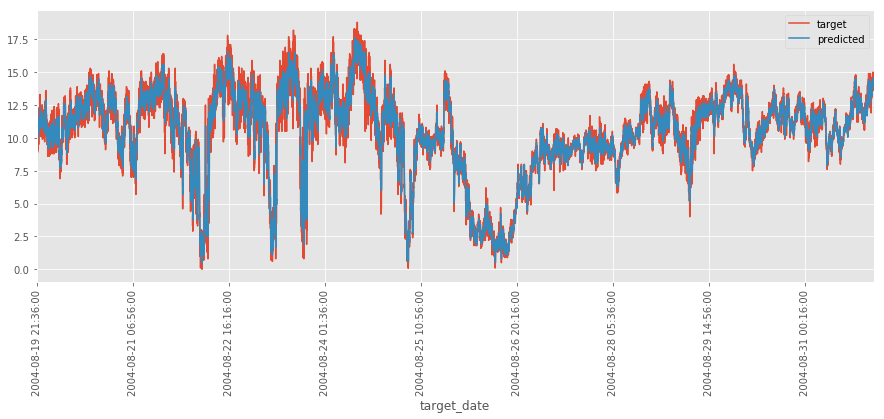

In [23]:
df_target.plot(figsize=(15,5), rot=90)

In [24]:
df_target.loc[:,'bias'] = df_target['target'] - df_target['predicted']

/Users/tmorales/interpreters/anaconda3/envs/p3tf1/lib/python3.5/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tmorales/interpreters/anaconda3/envs/p3tf1/lib/python3.5/site-packages/pandas/core/indexing.py:561: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


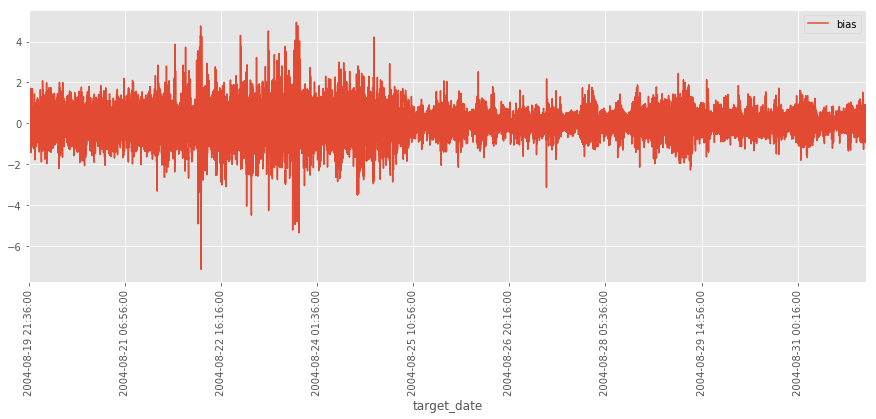

In [25]:
df_target[['bias']].plot(figsize=(15,5), rot=90)